In [1]:
# Netflix Data Science Project
# By: Zachary Delk
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# Downloading and Storing Dataset
working_path = kagglehub.dataset_download("shivamb/netflix-shows")
file_path = working_path + "/netflix_titles.csv"
df = pd.read_csv(file_path)

# Inspecting Data
print(df.head(3))
print(df.info())

/home/zack/workspace/github.com/zdelk/netflix_eda/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  show_id     type                 title         director  \
0      s1    Movie  Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show         Blood & Water              NaN   
2      s3  TV Show             Ganglands  Julien Leclercq   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021          2021  TV-MA   1 Season   

                                           listed_in  \
0                                      Documentaries   
1    International TV Shows, TV Dramas, TV Mysteries   
2  Crime TV Shows, International TV Shows, TV Act...   

                

In [2]:
df['type'] = df['type'].astype('category')
df['rating'] = df['rating'].astype('category')
df.dtypes

df[df == 'Not Given'] = np.nan

In [5]:
# Q1.What are the most prevalent categories?
# Some of the 'listed_in' have unneccessary keywords like 'TV' or 'Movies'
# So we want to remove them and then split the strings into lists 
# to get a better picture of what categories are most popular across the two
# media forms.

# Removing Uneccessary Keywords
substring_to_remove = ['TV', 'Shows', 'Movies']
pattern = "|".join(substring_to_remove)
df['listed_in'] = df['listed_in'].str.replace(pattern, "", regex=True)

# Converting Categories to lists
df['listed_in_list'] = df['listed_in'].str.split(',').apply(lambda x: [i.strip() for i in x])

# # Checking if it worked    
# df['listed_in_list'].head()

In [6]:
# Using the column of lists to make a Category dictionary
cat_dict = {}
for show in df['listed_in_list']:
    for cat in show:
        if cat in cat_dict:
            cat_dict[cat] += 1
        else:
            cat_dict[cat] = 1

[('International', 4103), ('Dramas', 3190), ('Comedies', 2255), ('Action & Adventure', 1027), ('Romantic', 986), ('Documentaries', 869), ('Independent', 756), ('Children & Family', 641), ('Thrillers', 634), ('Crime', 470)]


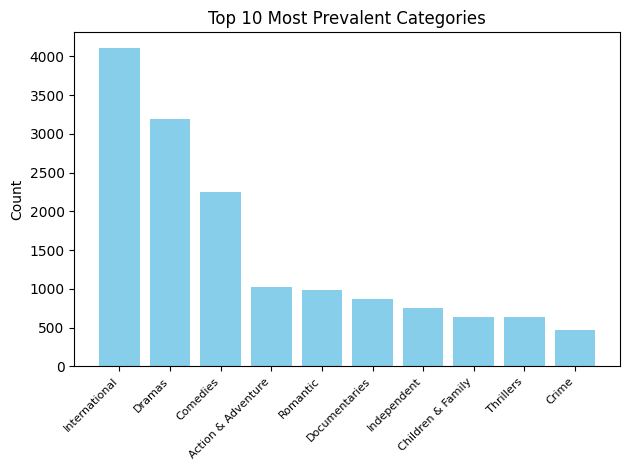

In [35]:
# Sorting Dictionary and Looking at 10 Most Prevalent Categories
sorted_cats = sorted(cat_dict.items(), key=lambda item: item[1], reverse=True)
top_10_cats = sorted_cats[:10]
print(top_10_cats)
categories, counts = zip(*top_10_cats)
plt.bar(x=categories, height=counts, color = 'skyblue')
plt.title('Top 10 Most Prevalent Categories')
plt.ylabel('Count')

plt.xticks(rotation=45, ha='right', fontsize = 8)
plt.tight_layout()

4306


<Axes: ylabel='Total'>

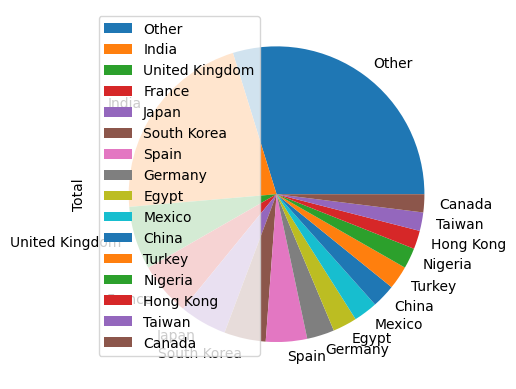

In [34]:
# Looks like 'International' the the most common category.
# Wonder where the content is coming from.

# Subset data to just relevant info
# Only worried about entries where 'International' is in the categories
subset_int = df[['country', 'listed_in_list', 'type']].dropna()
subset_int = subset_int[subset_int['listed_in_list'].apply(lambda x: 'International' in x)]

# Separating the country into list
subset_int['countries'] = subset_int['country'].str.split(r',\s*+', regex=True)

# Each country for each observation gets its own row
exploded = subset_int.explode('countries')

# Getting Counts of Tv Shows and Movies for each country
country_media_df = exploded.groupby(['countries','type'], observed=True).size().unstack(fill_value=0)

country_media_df['Total'] = country_media_df.sum(axis=1) # Total media for country
cm_sorted = country_media_df.sort_values(by='Total', axis=0, ascending=False) # Sorting by total count

# Dropping US since I live there
cm_sorted = cm_sorted.drop('United States')

ten_place = cm_sorted['Total'].iloc[14] # Count for 10th largest
print(cm_sorted['Total'].sum())
cm_sorted = cm_sorted.reset_index()
# If below rank 10 grouped to Other
cm_sorted['countries'] = cm_sorted['countries'].where(cm_sorted['Total'] >= ten_place, 'Other')

cm_grouped = (
    cm_sorted
    .groupby('countries')[['Movie', 'TV Show', 'Total']]
    .sum()
    .sort_values(by='Total', ascending=False)
)


cm_grouped.plot.pie(y='Total')

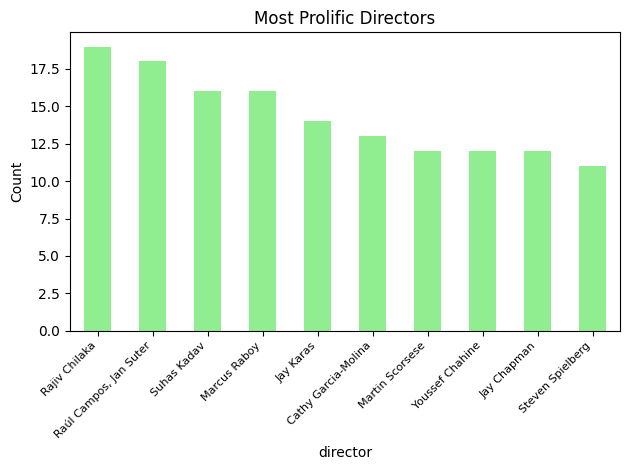

In [29]:
# - Who is/are the most prolific directors for each country?

directors = df['director']
top_10_dir = directors.value_counts()[:10]
top_10_dir.plot.bar(color='lightgreen')
plt.title('Most Prolific Directors')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right', fontsize = 8)
plt.tight_layout()


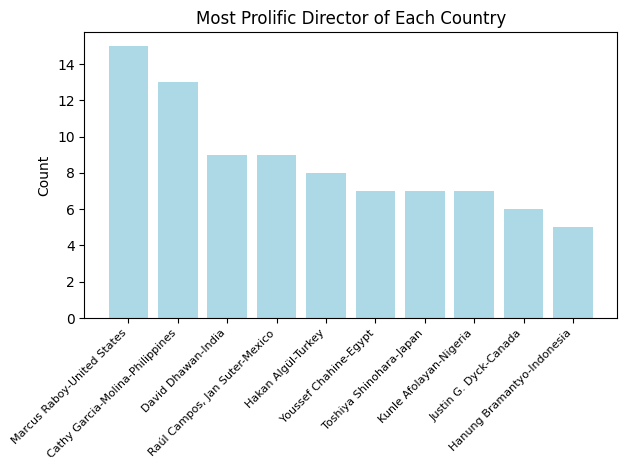

In [36]:
# Who is/are the most prolific directors for each country?
df_sub_dc = df.dropna(subset=['director','country'])
director_count = df_sub_dc.groupby(['country', 'director']).size().reset_index(name='count')
most_prolific = director_count.sort_values('count', ascending=False).drop_duplicates('country')

most_prolific['dir_country'] = most_prolific['director'] + '-' + most_prolific['country']


plt.bar(x=most_prolific['dir_country'].head(10), height=most_prolific['count'].head(10), color='lightblue')
plt.title('Most Prolific Director of Each Country')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right', fontsize = 8)
plt.tight_layout()

In [37]:
df_sub_dt = df.dropna(subset=['director', 'type'])
direct_type_count = df_sub_dc.groupby('director')['type'].nunique()
directors_both = direct_type_count[direct_type_count == 2].index.tolist()

In [38]:
len(directors_both)

35

In [47]:
# - Most common cast member?

# Isolate 'cast' column. Explode. Group by.
cast_list = df['cast'].str.split(r',\s*+', regex=True)

# Each country for each observation gets its own row
exploded = cast_list.explode('cast')
exploded.value_counts().sort_values(ascending=False)


cast
Anupam Kher          43
Shah Rukh Khan       35
Julie Tejwani        33
Takahiro Sakurai     32
Naseeruddin Shah     32
                     ..
Tejashree Pradhan     1
Neha Joshi            1
Ayesha Omer           1
Samina Peerzada       1
Waseem Abbas          1
Name: count, Length: 36439, dtype: int64

/tmp/ipykernel_42834/3204514252.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  release_group = subset_time.groupby(['type','release_year']).size().unstack(level=0,fill_value = 0)


<Axes: xlabel='release_year', ylabel='Movie'>

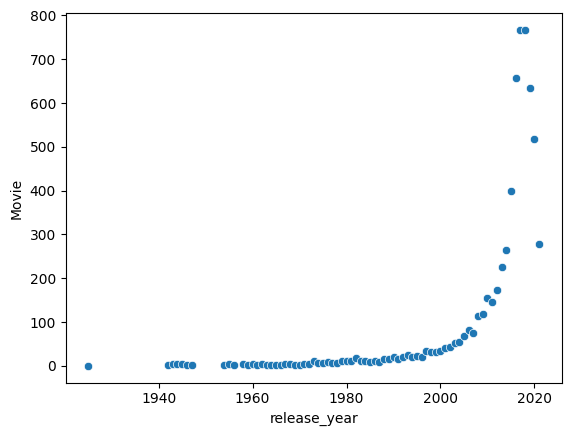

In [65]:
import seaborn as sns
# - Amount of releases by year split by TV Show or Movie
subset_time = df[['type','release_year']].dropna()
release_group = subset_time.groupby(['type','release_year']).size().unstack(level=0,fill_value = 0)
release_group = release_group.reset_index()
sns.scatterplot(data =release_group, x='release_year', y='Movie')
# plt.scatter(x=release_group['release_year'],y=release_group['Movie'])

In [ ]:
# - How long are the movies on average, by genre or by country?